# TSP Solver

This notebook intends to demonstrate the problem solving process step by step.
First we import all the required libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from ortools.linear_solver import pywraplp
from typing import Dict, List
from itertools import product, combinations

First, we define three classes to help solve the TSP.

In [12]:
class TspVisualizer:
    """visualize a TSP tour
    Codes are taken from https://kunlei.github.io/python-ortools-notes/ip-tsp.html
    As the author of the codes, Kunlei Lian grants permission of using the codes for solving the TSP this client needs.
    """
    
    @staticmethod
    def show(locations, edges):
        """draw TSP tour
        adapted from https://stackoverflow.com/a/50682819
        
        examples:
        locations = {
            0: (5, 5),
            1: (4, 9),
            2: (6, 4),
        }

        edges = [
            (0, 1),
            (1, 2),
            (2, 0),
        ]

        Args:
            locations (dict): location id -> (lat, lon)
            edges (list): list of edges
        """
        G = nx.DiGraph()
        G.add_edges_from(edges)
        plt.figure(figsize=(15,10))
        
        colors = mpl.colormaps["Set1"].colors
        color_idx = 1
        color = np.array([colors[color_idx]])
        
        nx.draw_networkx_nodes(G, 
                                locations, 
                                nodelist=[x[0] 
                                        for x in edges], 
                                node_color=color)
        nx.draw_networkx_edges(G,
                                locations, 
                                edgelist=edges,
                                width=4, 
                                edge_color=color, 
                                style='dashed')
        
        # labels
        nx.draw_networkx_labels(G, locations, 
                                font_color='w', 
                                font_size=12, 
                                font_family='sans-serif')

        #print out the graph
        plt.axis('off')
        plt.show()

In [13]:
class TspModelBase:
    """base class for TSP models
    Codes are taken from https://kunlei.github.io/python-ortools-notes/ip-tsp.html
    As the author of the codes, Kunlei Lian grants permission of using the codes for solving the TSP this client needs.
    """
    
    def __init__(self, name: str):
        self._name: str = name
        self._node_list: List[int] = None
        self._node_coords: Dict[int, List[float, float]] = None
        self._distance: Dict[int, Dict[int, int]] = None
        
    def read_inputs(self, customers: pd.DataFrame) -> None:
        self._name = 'tsp'
        self._node_list = customers.index.to_list()
        self._node_coords = {
            id: customers.loc[id, :].to_list()
            for id in self._node_list
        }
        
        self._distance = {}
        for i in self._node_list:
            dist = {
                j: np.sqrt(np.sum(np.square(np.array(self._node_coords[i]) - np.array(self._node_coords[j]))))
                for j in self._node_list
            }
            self._distance[i] = dist

    def get_combinations(self, size):
        return list(combinations(self._node_list, size))
        
    @property
    def name(self): return self._name
    
    @property
    def num_nodes(self): return len(self._node_coords)

In [14]:
class TspModel(TspModelBase):
    """model that solves tsp
    Codes are taken from https://kunlei.github.io/python-ortools-notes/ip-tsp.html
    As the author of the codes, Kunlei Lian grants permission of using the codes for solving the TSP this client needs.

    Args:
        TspModel (model): model
    """
    
    def __init__(self, name='TSP model'):
        super().__init__(name)
        
        self._solver = pywraplp.Solver.CreateSolver('SCIP')
        self._var_x = None
        self._var_y = None
        self._opt_obj = None
        self._opt_x = None
        self._opt_route = None
    
    def build_model(self):
        self._create_variables()
        self._create_objective()
        self._create_degree_constraints()
        self._create_subtour_elimination_constraints()
    
    def optimize(self, enable_output: bool):
        if enable_output: self._solver.EnableOutput()
        status = self._solver.Solve()
        if status is pywraplp.Solver.OPTIMAL:
            self._retrieve_opt_solution()
            self._retrieve_opt_route()
    
    def _create_variables(self):
        self._var_x = {}
        for i in self._node_list:
            self._var_x[i] = {
                j: self._solver.BoolVar(f'x_{i, j}')
                for j in self._node_list
                if j != i
            }
        
        infinity = self._solver.Infinity()
        self._var_y = {}
        for k in self._node_list[1:]:
            vars = {}
            for i in self._node_list:
                vars[i] = {
                    j: self._solver.NumVar(0, infinity, f'y_{i, j}')
                    for j in self._node_list
                    if j != i
                }
            self._var_y[k] = vars
        
    def _create_objective(self):
        node_list = self._node_list
        expr = [self._distance[i][j] * self._var_x[i][j]
                for i, j in product(node_list, node_list)
                if i != j]
        self._solver.Minimize(self._solver.Sum(expr))
        
    def _create_degree_constraints(self):
        for i in self._node_list:
            out_expr = [self._var_x[i][j]
                    for j in self._node_list
                    if j != i
                    ]
            in_expr = [self._var_x[j][i]
                        for j in self._node_list
                        if j != i
                    ]
            self._solver.Add(self._solver.Sum(out_expr) == 1)
            self._solver.Add(self._solver.Sum(in_expr) == 1)
    
    def _create_subtour_elimination_constraints(self):
        for k in self._node_list[1:]:
            for i, j in product(self._node_list, self._node_list):
                if i == j: continue
                self._solver.Add(self._var_y[k][i][j] <= self._var_x[i][j])
        
        for k in self._node_list[1:]:
            expr = [self._var_y[k][1][j]
                    for j in self._node_list
                    if j != 1]
            self._solver.Add(self._solver.Sum(expr) == 1)
            
            expr = [self._var_y[k][j][1]
                    for j in self._node_list
                    if j != 1]
            self._solver.Add(self._solver.Sum(expr) == 0)
            
            expr = [self._var_y[k][j][k]
                    for j in self._node_list
                    if j != k]
            self._solver.Add(self._solver.Sum(expr) == 1)

            expr = [self._var_y[k][k][j]
                    for j in self._node_list
                    if j != k]
            self._solver.Add(self._solver.Sum(expr) == 0)

        for j, k in product(self._node_list[1:], 
                            self._node_list[1:]):
            if j == k: continue
            expr1 = [self._var_y[k][i][j]
                    for i in self._node_list
                    if i != j]
            expr2 = [self._var_y[k][j][i]
                    for i in self._node_list
                    if i != j]
            self._solver.Add(self._solver.Sum(expr1) == 
                            self._solver.Sum(expr2))
        
    
    def _retrieve_opt_solution(self):
        self._opt_obj = float(self._solver.Objective().Value())
        self._opt_x = {}
        for i in self._node_list:
            self._opt_x[i] = {
                j: round(self._var_x[i][j].solution_value())
                for j in self._node_list
                if j != i
            }
            
        print(f'optimal value = {self._opt_obj:.2f}')
    
    def _retrieve_opt_route(self):
        self._opt_route = []
        route_start = list(self._opt_x.keys())[0]
        edge_start = route_start
        while True:
            for n in self._opt_x[edge_start]:
                if self._opt_x[edge_start][n] == 0: continue
                
                edge_end = n
                self._opt_route.append((edge_start, edge_end))
                break
            
            if edge_end == route_start: break
            edge_start = edge_end
            
    def show_opt_route(self):
        print(f'optimal route: {self._opt_route}')
        TspVisualizer.show(self._node_coords, self._opt_route)
        
        
    def show_model_info(self):
        print(f"Number of variables: {self._solver.NumVariables()}")
        print(f"Number of constraints: {self._solver.NumConstraints()}")

Finally, we put everything together and solve the problem.
The optimal route is shown after the solver finishes running.

Number of variables: 23548
Number of constraints: 23662
optimal value = 43.98
optimal route: [(1, 9), (9, 17), (17, 2), (2, 4), (4, 5), (5, 14), (14, 10), (10, 15), (15, 18), (18, 27), (27, 21), (21, 22), (22, 7), (7, 25), (25, 24), (24, 13), (13, 8), (8, 23), (23, 3), (3, 29), (29, 20), (20, 16), (16, 28), (28, 6), (6, 26), (26, 19), (19, 11), (11, 12), (12, 1)]


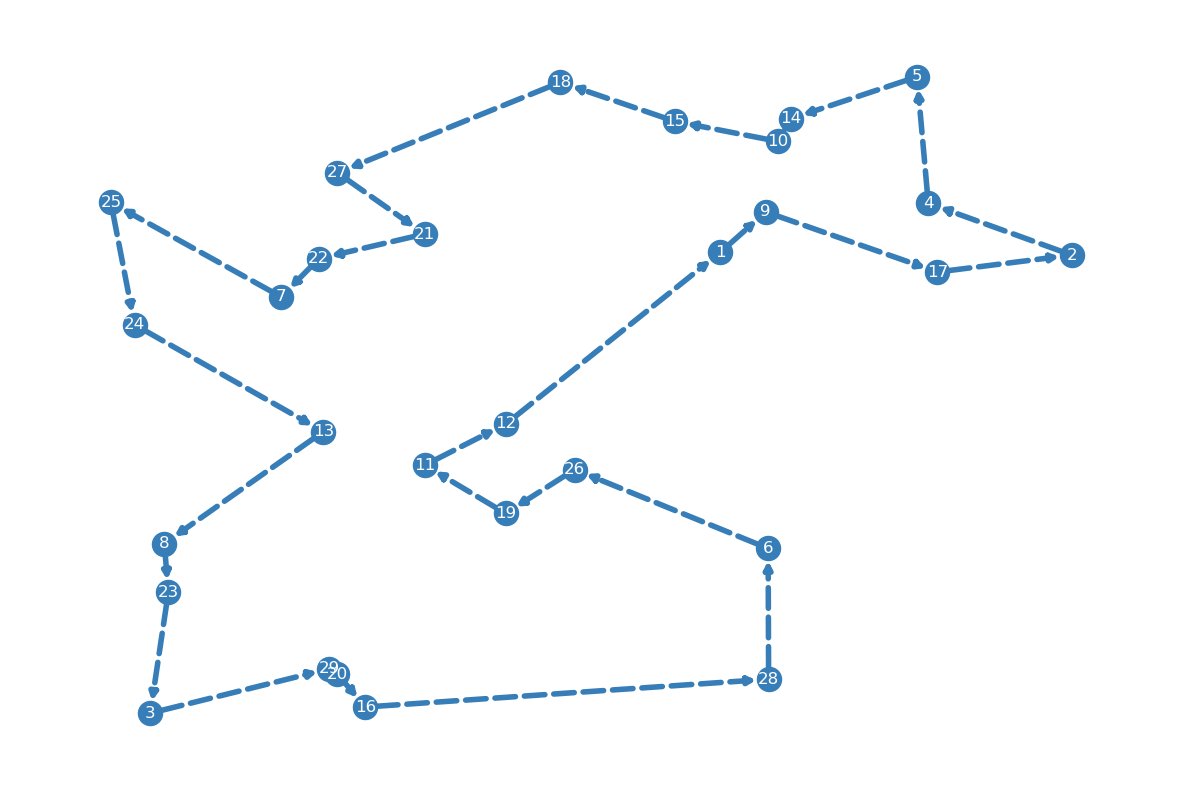

In [15]:
filename = '../inputs/tsp-customers-test1.xlsx'
df_customers = pd.read_excel(filename, sheet_name='customers')
df_customers = df_customers.set_index('id')

tsp_model = TspModel()
tsp_model.read_inputs(df_customers)
tsp_model.build_model()
tsp_model.show_model_info()
tsp_model.optimize(False)
tsp_model.show_opt_route()